# Clasificación de noticias de 20Newsgroup
**Author**: [albertobas](https://www.github.com/albertobas)<br />**Date created**: 10/03/2021<br />**Description**: clasificación de texto en el conjunto de datos de 20NewsGroup.

<a href="https://colab.research.google.com/github/albertobas/20-news-classification/blob/main/clasificacion_20_news.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br />
___

## Introducción

En este cuaderno se entrenan redes neuronales convolucionales y recurrentes para clasificar secuencias. Las secuencias utilizadas son el resultado de la vectorización de mensajes obtenidos del conjunto de datos [20NewsGroup](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) que contiene 20000 mensajes tomados de 20 newsgroup.


## Configuración

In [1]:
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
from utils import get_data, get_embedding_index, train, TwentyNewsDataset, Vectorizer
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 29
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

## Preprocesamiento de datos

In [2]:
texts, labels = get_data()

Extracting 20_newsgroups.tar.gz
Reading files


Los mensajes tienen varios encabezados en la parte superior. Uno de ellos es el campo de categoría que establece la etiqueta o la clase de la observación. La clase también puede estar presente en otros campos de los encabezados, a saber, _Followup-to_ o _Subject_.

In [3]:
sample = open(os.path.join(os.getcwd(), 'data', '20_newsgroups',
              "alt.atheism", "51198"), encoding="latin-1").read()
print(sample[890:1010]) # edit start and end indexes to see more text

> things which are eternal.  Jesus is a subset of God.   Therefore
>:> Jesus belongs to the set of things which are eter


Al [leer los archivos](utils/preprocessing.py), se elimina cualquier encabezado con una mención de la clase correspondiente. Además, también se eliminan los encabezados _Path_ y _Xref_ y los encabezados que contienen direcciones de correo electrónico.

Los textos se dividen para formar un conjunto de datos y un conjunto de validación.

Uso `train_test_split` para estratificar la división y tener una distribución proporcional de categorías entre ambos conjuntos, y se deja la última observación fuera del conjunto de datos de entrenamiento para hacer una predicción al final con fines de representación.

In [4]:
x_train, x_val, y_train, y_val = train_test_split(texts[:-1], labels[:-1],
                                                  random_state=SEED,
                                                  test_size=0.2,
                                                  stratify=labels[:-1])
x_sample, y_sample = texts[-1], labels[-1]


In [5]:
category_index = {c: i for i, c in enumerate(sorted(set(y_train)))}
index_category = {category_index[k]: k for k in category_index.keys()}
y_train = [category_index[c] for c in y_train]
y_val = [category_index[c] for c in y_val]

OUTPUT_DIM = len(category_index)

He escrito un [vectorizador](utils/preprocessing.py) para transformar los textos en secuencias. El método es simple, primero se instancia un objeto, configurado en este caso con una longitud máxima por secuencia de 200 tokens y un vocabulario con un número máximo de  tokens de 20000. 

Luego, el método `.fit` del objeto toma la matriz de entrenamiento como argumento para formar el vocabulario que se usará cada vez que se pase una matriz al método transform`. Transformar una matriz es tokenizar una cadena de caracteres y vectorizarla mapeando desde el vocabulario.

Las matrices de secuencias resultantes junto con sus correspondientes clases se pasan a `TwentyNewsDataset` para instanciar dos objetos `torch.utils.data.Dataset`, que se utilizarán en el entrenamiento de las redes neuronales.

In [6]:
# Text parameters
MAX_LEN = 200 
VOCAB_SIZE = 20000

v = Vectorizer(max_len=MAX_LEN, n_words=VOCAB_SIZE, normalize=False)
x_train_vectorized = v.fit_transform(x_train)
x_val_vectorized = v.transform(x_val)

if v.max_len is None:
    MAX_LEN = x_train_vectorized.size(1)
# The number of tokens is the total number of words in the vocabulary plus two 
# additional characters: <pad> and <unk>  
N_TOKENS = v.vocab_size

frame_train = TwentyNewsDataset(x_train_vectorized, torch.LongTensor(y_train))
frame_val = TwentyNewsDataset(x_val_vectorized, torch.LongTensor(y_val))

> Se puede encontrar un menor sobreajuste al conjunto de entrenamiento y, por lo tanto, una mayor precisión de validación, aumentando la longitud máxima de la secuencia. Por razones de rendimiento, he establecido una longitud relativamente baja.

## Modelado
En esta sección se entrenan cuatro modelos, dos redes convolucionales y dos redes recurrentes, usando [estas funciones de validación] (utils/validation.py).

Todos los modelos implementados comparten un flujo de trabajo similar, es decir, una representación multidimensional de las secuencias, un proceso de aprendizaje de características de alto nivel en los datos y una última fase de clasificación de las estimaciones.

Por eso he escrito un objeto simple que instanciaré en cada modelo y que reunirá los diferentes módulos a utilizar.

In [7]:
class TwentyNewsNet(nn.Module):

    def __init__(self, embedding, module, classifier, is_recurrent=False):
        super(TwentyNewsNet, self).__init__()
        self.embedding = embedding
        self.module = module
        self.classifier = classifier
        self.is_recurrent = is_recurrent
        self.pretrained_weights = pretrained_weights
        modules = [x for x in self.modules() if isinstance(x, nn.Conv1d) | isinstance(x, nn.Conv2d) |
                   isinstance(x, nn.LSTM) | isinstance(x, nn.GRU) | isinstance(x, nn.Embedding) |
                   isinstance(x, nn.Linear)]
        self._init_wnb(*modules)

    def forward(self, x):
        if self.is_recurrent:
            seq_lens, idx_sort = torch.LongTensor([seq for seq in
                                                   torch.sum((x > 0), dim=1)]).sort(0, descending=True)
            idx_unsort = np.argsort(idx_sort)
            x = x[idx_sort]
            x = self.embedding(x)
            x = self.module(x, seq_lens, idx_unsort)
        else:
            x = self.embedding(x)
            x = self.module(x)
        return self.classifier(x)

    def _init_wnb(self, *args):
        init_range = 0.05
        init_constant = 0
        for module in args:
            for name, param in module.named_parameters():
                if 'weight' in name:
                    if isinstance(module, nn.Embedding):
                        # from_pretained embedding is frozen
                        if module.weight.requires_grad:
                            nn.init.uniform_(
                                param.data, -init_range, init_range)
                    else:
                        nn.init.xavier_uniform_(param.data)
                elif 'bias' in name:
                    nn.init.constant_(param.data, init_constant)

### Embeddings

La siguiente clase se utilizará para aplicar una transformación multidimensional a las secuencias en el _forward pass_. El _backward pass_ hacia atrás solo alterará los parámetros de las embeddings si no están previamente entrenadas.

In [8]:
class Embedding(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, dropout=0, pretrained_weights=None, is_permute=False):
        super(Embedding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.is_permute = is_permute
        if pretrained_weights is None:
            self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=v.word_index[v.pad_token])
        else:
            self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
    
    def forward(self, x):
        # (N, L) -> (N, L, H)
        x = self.embedding((x))
        x = self.dropout(x)
        if self.is_permute:
            # (N, L, H) -> (N, H, L)
            return x.permute(0, 2, 1)
        else:
            return x

Al utilizar parámetros previamente entrenados en una de las redes neuronales convolucionales más adelante, descargo un índice GloVe (822 MB) con todos los pesos y creo un tensor de (20002, 100) o (`N_TOKENS`, `GLOVE_EMBEDDING_DIM`). Es decir, una matriz con todas las palabras del vocabulario más dos caracteres especiales y las 100 dimensiones correspondientes a cada token.

Si el índice GloVe no contiene un token del vocabulario, cada dimensión de ese token será igual a cero.

In [9]:
GLOVE_EMBEDDING_DIM = 100
found, missed = 0, 0
missed_list = []

embeddings_index = get_embedding_index(GLOVE_EMBEDDING_DIM)

pretrained_weights = np.zeros(
    (N_TOKENS, GLOVE_EMBEDDING_DIM)).astype("float32")
# pretrained_weights = np.random.uniform(
#     -1, 1, (N_TOKENS, GLOVE_EMBEDDING_DIM)).astype("float32")

for idx, word in v.index_word.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        pretrained_weights[idx] = embedding_vector
        found += 1
    else:
        missed += 1
        missed_list.append(word)

pretrained_weights = torch.from_numpy(pretrained_weights)
print("Found %d words. Missed %d." % (found, missed))
print(missed_list[:8])

Extracting glove.6B.zip
Found 18782 words. Missed 1220.
['<pad>', '<unk>', 'bhj', 'xterm', 'utexas', 'vnews', 'imho', 'openwindows']


A más del 90% de los tokens se les ha asignado parámetros previamente entrenados, algunos de los tokens no encontrados en el índice de GloVe se muestran arriba.

### Clasificador
He definido dos clasificadores, uno con una capa completamente conectada y otro con dos. Ambos incluyen un argumento de _dropout_ para poner a cero aleatoriamente un porcentaje de los elementos del tensor de entrada al clasificador.

In [10]:
class OneLayerClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim, dropout=0, log_softmax=True):
        super(OneLayerClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.log_softmax = log_softmax
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        if self.log_softmax:
            # (N, Hin) -> (N, Hout)
            return F.log_softmax(self.fc1(x), dim=1)
        else:
            # (N, Hin) -> (N, Hout)
            return self.fc1(x)


class TwoLayerClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0, log_softmax=True):
        super(TwoLayerClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.log_softmax = log_softmax
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # (N, Hin) -> (N, Hout)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        if self.log_softmax:
            # (N, Hin) -> (N, Hout)
            return F.log_softmax(self.fc2(x), dim=1)
        else:
            # (N, Hin) -> (N, Hout)
            return self.fc2(x)

In [11]:
# torch.utils.data.DataLoader parameters
params_data_loader = {'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'drop_last': False}

### CNN
Se entrenan dos modelos simples con redes convolucionales:
- la primera versión es una red con tres capas de convolución de una dimensión con _max pooling_, que usa como embeddings de entrada parámetros ya entrenados de 100 dimensiones, y que tiene en la salida un clasificador de dos capas.

- la segunda versión es una red con cuatro capas de convolución 1-d con _max pooling_, una capa de embeddings de entrada de 128-d y en la salida un clasificador de una capa.

He establecido regularización L2 y un 50 % y un 40 % de _dropout_ en cada clasificador respectivamente, para tratar de solucionar un problema del sobreajuste del conjunto de entrenamiento. Esto tiene un mejor resultado en la segunda red convolucional.

Los hiper parámetros se enumeran en la parte superior de cada celda de código correspondiente.

#### CNN v1

In [12]:
class CNNv1(nn.Module):
    
    def __init__(self, input_dim, channels, kernel_sizes, window_sizes):
        super(CNNv1, self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv1d(input_dim, channels[0], kernel_sizes[0])
        self.pool1 = nn.MaxPool1d(window_sizes[0])
        self.conv2 = nn.Conv1d(channels[0], channels[1], kernel_sizes[1])
        self.pool2 = nn.MaxPool1d(window_sizes[1])
        self.conv3 = nn.Conv1d(channels[1], channels[2], kernel_sizes[2])
    
    def forward(self, x):
        # (N, H, Lin) -> (N, Cout, Lout)
        x = self.pool1(F.relu(self.conv1(x)))
        # (N, Cin, Lin) -> (N, Cout, Lout)
        x = self.pool2(F.relu(self.conv2(x)))
        # (N, Cin, Lin) -> (N, Cout)
        return torch.max(F.relu(self.conv3(x)), 2).values
    
    def input_dim(self):
        return self.channels[-1]

Epoch 1: 100%|##########| 125/125 01:28, _lr=0.001, acc=38.63, loss=1.7733, val_acc=36.3, val_loss=1.817
Epoch 2: 100%|##########| 125/125 01:28, _lr=0.001, acc=58.51, loss=1.2042, val_acc=54.38, val_loss=1.3056
Epoch 3: 100%|##########| 125/125 01:29, _lr=0.001, acc=66.71, loss=0.9462, val_acc=60.83, val_loss=1.1022
Epoch 4: 100%|##########| 125/125 01:30, _lr=0.001, acc=73.84, loss=0.7454, val_acc=66.08, val_loss=0.9699
Epoch 5: 100%|##########| 125/125 01:31, _lr=0.001, acc=78.12, loss=0.631, val_acc=68.3, val_loss=0.9247
Epoch 6: 100%|##########| 125/125 01:30, _lr=0.001, acc=83.99, loss=0.4739, val_acc=72.53, val_loss=0.821
Epoch 7: 100%|##########| 125/125 01:31, _lr=0.001, acc=81.81, loss=0.4913, val_acc=69.7, val_loss=0.9192
Epoch 8: 100%|##########| 125/125 01:32, _lr=0.00075, acc=89.92, loss=0.3059, val_acc=74.92, val_loss=0.7851
Epoch 9: 100%|##########| 125/125 01:31, _lr=0.00075, acc=92.07, loss=0.2449, val_acc=76.08, val_loss=0.7676
Epoch 10: 100%|##########| 125/125 01:3

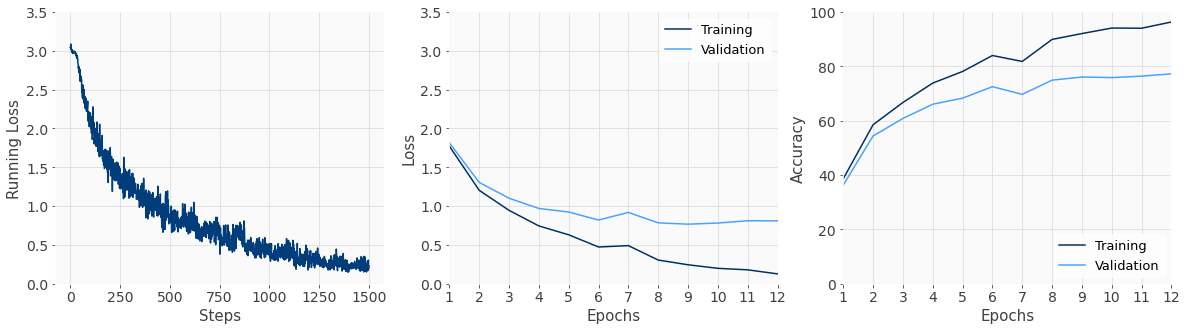

In [13]:
# Model parameters
CHANNELS = [128, 128, 128]
HIDDEN_DIM = 128
KERNEL_SIZES = [5, 5, 5]
WINDOW_SIZES = [5, 5]
DROPOUT = 0.5

cnn_v1_embedding = Embedding(N_TOKENS, GLOVE_EMBEDDING_DIM, pretrained_weights=pretrained_weights,
                             is_permute=True)
cnn_v1_module = CNNv1(GLOVE_EMBEDDING_DIM, CHANNELS,
                      KERNEL_SIZES, WINDOW_SIZES)
cnn_v1_classifier = TwoLayerClassifier(
    cnn_v1_module.input_dim(), HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
cnn_v1 = TwentyNewsNet(cnn_v1_embedding, cnn_v1_module, cnn_v1_classifier)

# Training parameters
params_train = {'data_loader': {'batch_size': 128,
                                'shuffle': True, 'num_workers': 2, 'drop_last': False}}
params_train['epochs'] = 12
params_train['criterion'] = {'name': 'nll_loss'}
params_train['optimizer'] = {'name': 'Adam',
                             'config': {'lr': 1e-3, 'weight_decay': 1e-3}}
params_train['scheduler'] = {'name': 'ReduceLROnPlateau',
                             'config': {'factor': 0.75, 'min_lr': 5e-4, 'mode': 'max', 'patience': 0},
                             'step': {'metric': 'val_acc'}}
params_eval = {k: params_train['data_loader'][k]
               for k in params_train['data_loader'].keys() if k != 'shuffle'}

train(cnn_v1, frame_train, frame_val, params_train, params_eval)

#### CNN v2

In [14]:
class CNNv2(nn.Module):

    def __init__(self, input_dim, channel, kernel_sizes, max_len, is_batch_norm=False):
        super(CNNv2, self).__init__()
        self.convs = nn.ModuleList(
            [nn.Conv1d(1, channel, (K, input_dim)) for K in kernel_sizes])
        self.pools = nn.ModuleList(
            [nn.MaxPool1d(self._conv_out_shape(conv, max_len)) for conv in self.convs])

    def forward(self, x):
        # [(N, L, H) -> (N, 1, L, H) -> (N, Cout, L, 1) -> (N, Cout, L) -> (N, Cout, 1) -> (N, Cout), ...]
        x = [self.pools[i](F.relu(self.convs[i](x.unsqueeze(1)).squeeze(3))).squeeze(2)
             for i in range(len(self.convs))]
        # (N, Cout) -> (N, Cout x len(self.convs))
        return torch.cat(x, 1)

    def _conv_out_shape(self, conv, max_len):
        return ((max_len + (2 * conv.padding[0]) - (conv.dilation[0] * (conv.kernel_size[0] - 1)) - 1) //
                conv.stride[0]) + 1

Epoch 1: 100%|##########| 125/125 05:20, _lr=0.001, acc=49.1, loss=1.7303, val_acc=47.7, val_loss=1.762
Epoch 2: 100%|##########| 125/125 05:24, _lr=0.001, acc=72.45, loss=0.9756, val_acc=68.75, val_loss=1.071
Epoch 3: 100%|##########| 125/125 05:18, _lr=0.001, acc=78.88, loss=0.7288, val_acc=73.35, val_loss=0.8853
Epoch 4: 100%|##########| 125/125 05:21, _lr=0.001, acc=82.51, loss=0.616, val_acc=75.72, val_loss=0.8018
Epoch 5: 100%|##########| 125/125 05:18, _lr=0.001, acc=84.56, loss=0.5546, val_acc=76.8, val_loss=0.7622
Epoch 6: 100%|##########| 125/125 05:35, _lr=0.001, acc=85.92, loss=0.4984, val_acc=77.8, val_loss=0.731
Epoch 7: 100%|##########| 125/125 08:26, _lr=0.001, acc=86.81, loss=0.4582, val_acc=77.72, val_loss=0.7056
Epoch 8: 100%|##########| 125/125 07:55, _lr=0.00075, acc=87.84, loss=0.4268, val_acc=78.3, val_loss=0.6861
Epoch 9: 100%|##########| 125/125 05:44, _lr=0.00075, acc=88.78, loss=0.4105, val_acc=78.5, val_loss=0.6797
Epoch 10: 100%|##########| 125/125 05:31, _

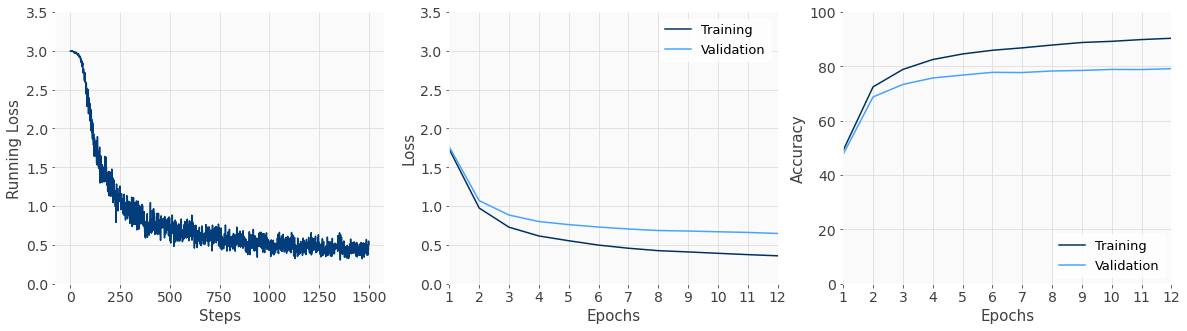

In [15]:
# Model parameters
CHANNELS = 128
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
KERNEL_SIZES = [1, 2, 3, 4]
DROPOUT = 0.4

cnn_v2_embedding = Embedding(N_TOKENS, EMBEDDING_DIM, is_permute=False)
cnn_v2_module = CNNv2(EMBEDDING_DIM, CHANNELS, KERNEL_SIZES, MAX_LEN)
cnn_v2_classifier = OneLayerClassifier(
    len(KERNEL_SIZES)*CHANNELS, OUTPUT_DIM, DROPOUT)
cnn_v2 = TwentyNewsNet(cnn_v2_embedding, cnn_v2_module, cnn_v2_classifier)

# Training parameters
params_train.clear()
params_train = {'data_loader': {'batch_size': 128,
                                'shuffle': True, 'num_workers': 2, 'drop_last': False}}
params_train['epochs'] = 12
params_train['criterion'] = {'name': 'nll_loss'}
params_train['optimizer'] = {'name': 'Adam',
                             'config': {'lr': 1e-3, 'weight_decay': 1e-3}}
params_train['scheduler'] = {'name': 'ReduceLROnPlateau',
                             'config': {'factor': 0.75, 'min_lr': 5e-4, 'mode': 'max', 'patience': 0},
                             'step': {'metric': 'val_acc'}}
params_eval.clear()
params_eval = {k: params_train['data_loader'][k]
               for k in params_train['data_loader'].keys() if k != 'shuffle'}

train(cnn_v2, frame_train, frame_val, params_train, params_eval)


### RNN
Por último, he entrenado dos redes neuronales recurrentes:
- una con un LSTM monocapa bidireccional y un mecanismo de autoatención.

- y otra con GRU monocapa bidireccional y mecanismo de autoatención.

Ambos tienen una capa de _embeddings_ de 128 dimensiones y un clasificador de una capa. Sin embargo, solo he configurado _dropout_ en el LSTM.

Logramos una mejor precisión de validación con las redes recurrentes, aunque parece haber un sobreajuste más notable, como podemos ver en los gráficos a continuación durante el proceso de aprendizaje.

In [16]:
class RNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, rnn_type='LSTM', n_layers=1, is_bidirectional=True,
                 is_batch_first=True):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.is_bidirectional = is_bidirectional
        self.is_batch_first = is_batch_first
        self.num_directions = 2 if is_bidirectional else 1
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn_type = rnn_type
            self.rnn = getattr(nn, rnn_type)(input_dim, hidden_dim, n_layers, bidirectional=is_bidirectional,
                                             batch_first=self.is_batch_first)
        else:
            raise ValueError("The rnn_type allowed are 'LSTM' and 'GRU'.")
        self.attention = Attention(self.output_dim())

    def forward(self, x, seq_lens, idx_unsort):
        batch_size, total_length = x.size(0), x.size(1)
        x = pack_padded_sequence(x, seq_lens, batch_first=self.is_batch_first)
        x, _ = self.rnn(x)
        x = pad_packed_sequence(
            x, batch_first=self.is_batch_first, total_length=total_length)[0]
        return self.attention(x[idx_unsort])

    def output_dim(self):
        return self.hidden_dim * self.num_directions


class Attention(nn.Module):

    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        # (N, L, Hin) -> (N, L, Hout)
        energy = torch.tanh(self.fc1(x))
        # (N, L, Hin) -> (N, L, 1)
        energy = self.fc2(x)
        # (N, L, 1) -> (N, L)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        # (N, L, Hin) x (N, L, 1) -> (N, Hin)
        return(x * weights.unsqueeze(-1)).sum(dim=1)

#### LSTM

Epoch 1: 100%|##########| 125/125 25:52, _lr=0.00125, acc=22.64, loss=2.228, val_acc=21.27, val_loss=2.2657
Epoch 2: 100%|##########| 125/125 26:08, _lr=0.00125, acc=47.59, loss=1.4819, val_acc=43.17, val_loss=1.6091
Epoch 3: 100%|##########| 125/125 26:22, _lr=0.00125, acc=70.71, loss=0.9728, val_acc=63.15, val_loss=1.1498
Epoch 4: 100%|##########| 125/125 26:10, _lr=0.00125, acc=84.95, loss=0.5133, val_acc=75.17, val_loss=0.7902
Epoch 5: 100%|##########| 125/125 25:50, _lr=0.00125, acc=89.73, loss=0.3516, val_acc=77.9, val_loss=0.7519
Epoch 6: 100%|##########| 125/125 25:50, _lr=0.00125, acc=92.67, loss=0.2497, val_acc=80.6, val_loss=0.6365
Epoch 7: 100%|##########| 125/125 25:53, _lr=0.00125, acc=94.94, loss=0.1708, val_acc=81.12, val_loss=0.6142
Epoch 8: 100%|##########| 125/125 26:01, _lr=0.00125, acc=95.66, loss=0.1337, val_acc=81.45, val_loss=0.6344


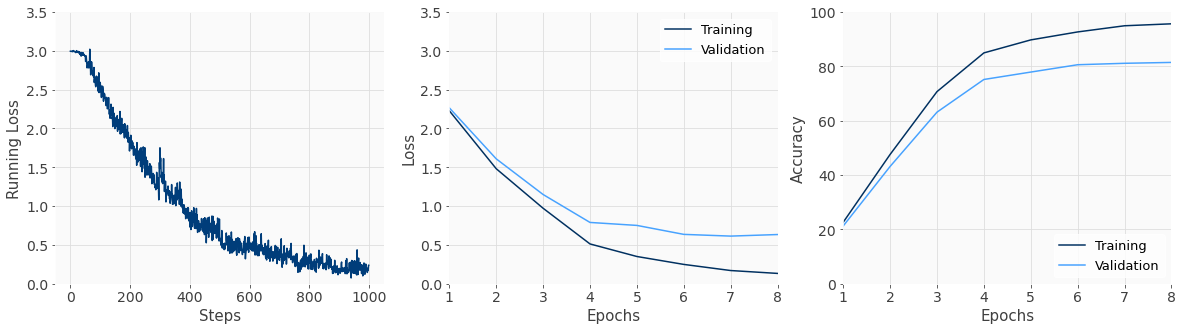

In [17]:
# Model parameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 100
DROPOUT = 0.4

lstm_v2_embedding = Embedding(N_TOKENS, EMBEDDING_DIM)
lstm_v2_module = RNN(EMBEDDING_DIM, HIDDEN_DIM,
                     rnn_type='LSTM', is_bidirectional=True)
lstm_v2_classifier = OneLayerClassifier(
    lstm_v2_module.output_dim(), OUTPUT_DIM, DROPOUT)
lstm = TwentyNewsNet(lstm_v2_embedding, lstm_v2_module,
                     lstm_v2_classifier, is_recurrent=True)


# Training parameters
params_train.clear()
params_train = {'data_loader': params_data_loader}
params_train['epochs'] = 8
params_train['criterion'] = {'name': 'nll_loss'}
params_train['optimizer'] = {'name': 'Adam',
                             'config': {'lr': 1.25e-3}}
params_train['scheduler'] = {'name': 'ReduceLROnPlateau',
                             'config': {'factor': 0.75, 'min_lr': 5e-4, 'mode': 'max', 'patience': 0},
                             'step': {'metric': 'val_acc'}}
params_eval.clear()
params_eval = {k: params_train['data_loader'][k]
               for k in params_train['data_loader'].keys() if k != 'shuffle'}

train(lstm, frame_train, frame_val, params_train, params_eval)


#### GRU

Epoch 1: 100%|##########| 125/125 20:34, _lr=0.001, acc=36.02, loss=1.9454, val_acc=34.58, val_loss=1.9851
Epoch 2: 100%|##########| 125/125 20:39, _lr=0.001, acc=72.09, loss=0.8042, val_acc=65.38, val_loss=0.9818
Epoch 3: 100%|##########| 125/125 20:35, _lr=0.001, acc=87.88, loss=0.4229, val_acc=79.28, val_loss=0.6773
Epoch 4: 100%|##########| 125/125 22:06, _lr=0.001, acc=92.04, loss=0.276, val_acc=80.55, val_loss=0.6356
Epoch 5: 100%|##########| 125/125 21:56, _lr=0.001, acc=95.18, loss=0.1632, val_acc=81.85, val_loss=0.6045
Epoch 6: 100%|##########| 125/125 21:57, _lr=0.001, acc=96.73, loss=0.1048, val_acc=82.78, val_loss=0.5832


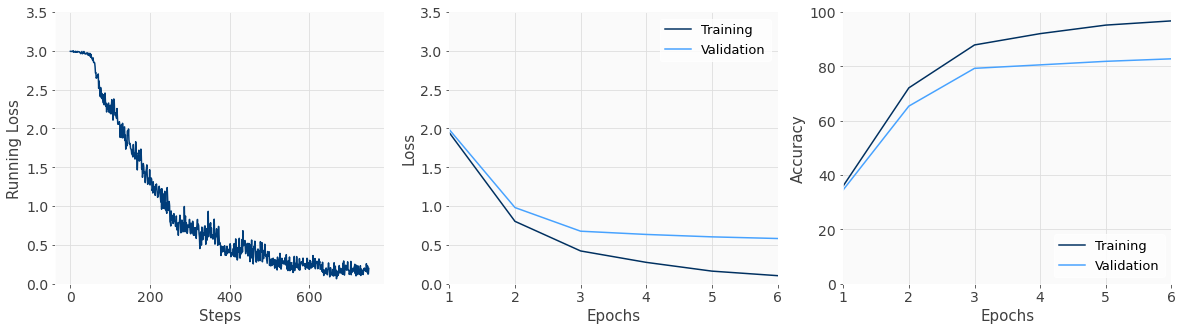

In [18]:
# Model parameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 100

gru_embedding = Embedding(N_TOKENS, EMBEDDING_DIM, is_permute=False)
gru_module = RNN(EMBEDDING_DIM, HIDDEN_DIM,
                 rnn_type='GRU', is_bidirectional=True)
gru_classifier = OneLayerClassifier(
    gru_module.output_dim(), OUTPUT_DIM, DROPOUT)
gru = TwentyNewsNet(gru_embedding, gru_module,
                    gru_classifier, is_recurrent=True)


# Training parameters
params_train.clear()
params_train = {'data_loader': params_data_loader}
params_train['epochs'] = 6
params_train['criterion'] = {'name': 'nll_loss'}
params_train['optimizer'] = {'name': 'Adam',
                             'config': {'lr': 1e-3}}
params_train['scheduler'] = {'name': 'ReduceLROnPlateau',
                             'config': {'factor': 0.75, 'min_lr': 5e-4, 'mode': 'max', 'patience': 0},
                             'step': {'metric': 'val_acc'}}
params_eval.clear()
params_eval = {k: params_train['data_loader'][k]
               for k in params_train['data_loader'].keys() if k != 'shuffle'}

train(gru, frame_train, frame_val, params_train, params_eval)


Aumentar la regularización no soluciona este problema. Por tanto, una solución podría ser aumentar la longitud de las secuencias.

## Predicción
A continuación podemos ver el flujo de trabajo utilizado para realizar una única predicción:

In [19]:
def predict(model, data):
    model.eval()
    _, y_pred = torch.max(model(v.transform(data)), 1)
    return index_category[y_pred.item()]

In [20]:
x_sample[:500]

'Subject: Re: After 2000 years, can we say that Christian Morality is\nDate: 24 Apr 1993 14:03:44 -0700\nOrganization: EIT\nLines: 126\nNNTP-Posting-Host: squick.eitech.com\n\n>#>Ordinarily, it is also a *value* judgement, though it needn\'t be (one \n>#>could "do science" without believing it was worth a damn in any context, \n>#>though that hardly seems sensible).\n>#No, you\'re just overloading the word "value" again. It is an\n>#estimation of probability of correctness, not an estimation of "worth."\n>#Sh'

In [21]:
format_string = "{}{}"
print(format_string.format('Model'.ljust(10), 'Prediction'))
print(format_string.format('-----'.ljust(10), '----------'))

for model in zip(['CNN_v1', 'CNN_v2', 'LSTM', 'GRU'], [cnn_v1, cnn_v2, lstm, gru]):
    y_pred = predict(model[1], [x_sample])
    print(format_string.format(model[0].ljust(10), y_pred))

print("\nLabel: {}".format(y_sample))

Model     Prediction
-----     ----------
CNN_v1    alt.atheism
CNN_v2    talk.religion.misc
LSTM      talk.religion.misc
GRU       talk.religion.misc

Label: talk.religion.misc


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
